In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import LSTM, GRU
from keras.optimizers import RMSprop
import numpy as np
import random
import sys
import io
import os
import requests
import random
import numpy as np
from bs4 import BeautifulSoup
import tensorflow as tf
# tf.enable_eager_execution()

Using TensorFlow backend.


In [0]:
print(np.__version__)
print(tf.__version__)

1.17.4
1.15.0


In [0]:
BASE_PATH = 'http://export.arxiv.org/api/query'
CATEGORIES = [
    'Machine Learning',
    'Natural Language Processing',
    'Neural Networks',
    'Artifical Intelligence'
]
KEYWORDS = [
    'neural',
    'intelligence'
    'network',
    'deep'    
]

In [0]:
def build_url(amount, offset):
    categories = ' OR '.join('cat:' + x for x in CATEGORIES)
    keywords = ' OR '.join('all:' + x for x in KEYWORDS)

    url = BASE_PATH
    url += '?search_query=(({}) AND ({}))'.format(categories, keywords)
    url += '&max_results={}&offset={}'.format(amount, offset)
    
    return url

In [0]:
def get_count():
    url = build_url(0, 0)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    count = int(soup.find('opensearch:totalresults').string)
    print(count, 'papers found')
    
    return count

In [0]:

num_papers = get_count()

67242 papers found


In [0]:
PAGE_SIZE = 100

def fetch_page(amount, offset):
    url = build_url(amount, offset)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    for entry in soup.findAll('entry'):
        text = entry.find('summary').text
        text = text.strip().replace('\n', ' ')
        yield text

def fetch_all():
    for offset in range(0, num_papers, PAGE_SIZE):
        print('Fetch papers {}/{}'.format(offset + PAGE_SIZE, num_papers))
        
        for page in fetch_page(PAGE_SIZE, offset):
            yield page

In [0]:
# DOWNLOADED_FILENAME = 'arxiv_data_abstracts.txt'
DOWNLOADED_FILENAME = 'sample_data.txt'

def download_data():
    if not os.path.isfile(DOWNLOADED_FILENAME):
        with open(DOWNLOADED_FILENAME, 'w') as file_:
            for abstract in fetch_all():
                file_.write(abstract + '\n')
    with open(DOWNLOADED_FILENAME) as file_:
        data = file_.readlines()
        
    return data    

In [0]:
data = download_data()

In [0]:
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 250

In [0]:
VOCABULARY = \
        " $%'()+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ" \
        "\\^_abcdefghijklmnopqrstuvwxyz{|}"

In [0]:
lookup = {x: i for i, x in enumerate(VOCABULARY)}

In [0]:
def one_hot(batch, sequence_length = MAX_SEQUENCE_LENGTH):
    one_hot_batch = np.zeros((len(batch), sequence_length, len(VOCABULARY)))

    # Iterate through every line of text in a batch
    for index, line in enumerate(batch):
        line = [x for x in line if x in lookup]
        assert 2 <= len(line) <= MAX_SEQUENCE_LENGTH
        
        # Iterate through every character in a line
        for offset, character in enumerate(line):
            # Code is the index of the character in the vocabulary
            code = lookup[character]
 
            one_hot_batch[index, offset, code] = 1
    
    return one_hot_batch

In [0]:
def next_batch():
    windows = []
    for line in data:
        for i in range(0, len(line) - MAX_SEQUENCE_LENGTH + 1, MAX_SEQUENCE_LENGTH // 2):
            windows.append(line[i: i + MAX_SEQUENCE_LENGTH])

    while True:
        random.shuffle(windows)
        for i in range(0, len(windows), BATCH_SIZE):
            batch = windows[i: i + BATCH_SIZE]
            yield one_hot(batch)

In [0]:
test_batch = None
for batch in next_batch():
    test_batch = batch
    print(batch.shape)
    break

(250, 100, 83)


In [0]:
tf.reset_default_graph()

In [0]:
sequence = tf.placeholder(tf.float32, [None, MAX_SEQUENCE_LENGTH, len(VOCABULARY)])

X = tf.slice(sequence, (0, 0, 0), (-1, MAX_SEQUENCE_LENGTH - 1, -1))

y = tf.slice(sequence, (0, 1, 0), (-1, -1, -1))

In [0]:
def get_mask(target):
    mask = tf.compat.v1.reduce_max(tf.abs(target), reduction_indices=2)
    return mask

def get_sequence_length(target):
    mask = get_mask(target)
    sequence_length = tf.compat.v1.reduce_sum(mask, reduction_indices=1)
    
    return sequence_length

In [0]:
num_neurons = 200
cell_layers = 2

num_steps = MAX_SEQUENCE_LENGTH - 1
num_classes = len(VOCABULARY)

In [0]:
sequence_length = get_sequence_length(y)

In [0]:
def build_rnn(data, num_steps, sequence_length, initial=None):
    cell = tf.nn.rnn_cell.LSTMCell(num_neurons)

    multi_cell = tf.nn.rnn_cell.MultiRNNCell(
        [tf.compat.v1.nn.rnn_cell.LSTMCell(num_neurons) for _ in range(cell_layers)])

    output, state = tf.nn.dynamic_rnn(
        inputs=data,
        cell=multi_cell,
        dtype=tf.float32,
        initial_state=initial,
        sequence_length=sequence_length)

    # Shared softmax layer across all RNN cells
    weight = tf.Variable(tf.truncated_normal([num_neurons, num_classes], stddev=0.01))
    bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))

    flattened_output = tf.reshape(output, [-1, num_neurons])

    prediction = tf.nn.softmax(tf.matmul(flattened_output, weight) + bias)
    prediction = tf.reshape(prediction, [-1, num_steps, num_classes])

    return prediction, state

In [0]:
prediction, _ = build_rnn(X, num_steps, sequence_length)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
mask = get_mask(y)

prediction = tf.clip_by_value(prediction, 1e-10, 1.0)

cross_entropy = y * tf.log(prediction)
cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)

cross_entropy *= mask

In [0]:
length = tf.reduce_sum(sequence_length, 0)

cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1) / length
cross_entropy = tf.reduce_mean(cross_entropy)

In [0]:
logprob = tf.multiply(prediction, y)
logprob = tf.reduce_max(logprob, reduction_indices=2)
logprob = tf.log(tf.clip_by_value(logprob, 1e-10, 1.0)) / tf.log(2.0)

In [0]:
logprob *= mask

length = tf.reduce_sum(sequence_length, 0)

logprob = tf.reduce_sum(logprob, reduction_indices=1) / length
logprob = tf.reduce_mean(logprob)

In [0]:
optimizer = tf.train.RMSPropOptimizer(0.002)

gradient = optimizer.compute_gradients(cross_entropy)

optimize = optimizer.apply_gradients(gradient)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
num_epochs = 100
epoch_size = 50

logprob_evals = []

In [0]:
checkpoint_dir = './sample_data_checkpoint_output'

In [0]:
perplexity_set = []
with tf.Session() as sess:
    
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    for epoch in range(num_epochs):
        for _ in range(epoch_size):
            batch = next(next_batch())
            
            logprob_eval, _ = sess.run((logprob, optimize), {sequence: batch})
            
            logprob_evals.append(logprob_eval)
            
        saver.save(sess, os.path.join(checkpoint_dir, 'char_pred'), epoch)    
        
        perplexity = 2 ** -(sum(logprob_evals[-epoch_size:]) /
                            epoch_size)
        perplexity_set.append(perplexity)
        print('Epoch {:2d} perplexity {:5.4f}'.format(epoch, perplexity))

Epoch  0 perplexity 1.0178
Epoch  1 perplexity 1.0178
Epoch  2 perplexity 1.0178
Epoch  3 perplexity 1.0174
Epoch  4 perplexity 1.0127


In [0]:
perplexity_set

[1.0178333664259882,
 1.0178311872369465,
 1.0178023040861288,
 1.0175435292276902,
 1.0129018785322832,
 1.012387913484009,
 1.0123563375371132,
 1.0123375463924995,
 1.0123026607738421,
 1.0123059796754068,
 1.0122925123514084,
 1.0122903165337562,
 1.0122844132961535,
 1.012287658687206,
 1.0122747948357116,
 1.0122717639532797,
 1.0122714292221284,
 1.0122580145297573,
 1.012261418574398,
 1.0122519680345579,
 1.0122576516261097,
 1.0122543860741744,
 1.0122422225387393,
 1.0122453373923337,
 1.0122397677784358,
 1.0122366933508904,
 1.0122249658954885,
 1.0122205033599778,
 1.0122053391352082,
 1.0121820242626098,
 1.012149366586744,
 1.0120777715160447,
 1.011964080244161,
 1.0118363690223395,
 1.0117006581404504,
 1.011546180359544,
 1.0113310207974178,
 1.011116601167856,
 1.0108817282651412,
 1.0106999018443195,
 1.010554726424775,
 1.0104162626290385,
 1.0103067957592,
 1.0101768715548631,
 1.010075720867131,
 1.009975751086736,
 1.0098521061184071,
 1.0097471241467075,
 1.00

In [0]:
input_set = list(range(0,100))

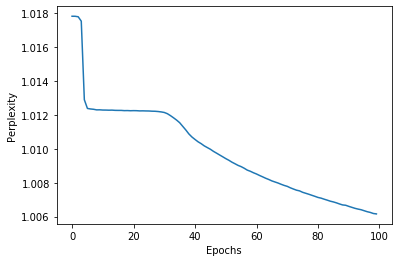

In [0]:
import matplotlib.pyplot as plt

plt.plot(input_set, perplexity_set)
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.show()

In [0]:
text = open('arxiv_mini.txt', 'r').read().lower()
chars = sorted(list(set(text)))

In [0]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [4]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 172281


In [0]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
model = Sequential()
model.add(LSTM(200, input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
def on_epoch_end(epoch, logs):

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
# print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [0]:
from keras.callbacks import ModelCheckpoint

filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [12]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.001)
callbacks = [checkpoint, reduce_lr]
model.fit(x, y, batch_size=100, epochs=5, callbacks=callbacks)

Epoch 1/5
172281/172281 [==============================] - 187s 1ms/step - loss: 2.8757

Epoch 00001: loss improved from 2.88515 to 2.87570, saving model to weights.hdf5
Epoch 2/5
172281/172281 [==============================] - 188s 1ms/step - loss: 2.8745

Epoch 00002: loss improved from 2.87570 to 2.87446, saving model to weights.hdf5
Epoch 3/5
172281/172281 [==============================] - 187s 1ms/step - loss: 2.8727

Epoch 00003: loss improved from 2.87446 to 2.87267, saving model to weights.hdf5
Epoch 4/5
172281/172281 [==============================] - 187s 1ms/step - loss: 2.8721

Epoch 00004: loss improved from 2.87267 to 2.87207, saving model to weights.hdf5
Epoch 5/5
172281/172281 [==============================] - 188s 1ms/step - loss: 2.8736

Epoch 00005: loss did not improve from 2.87207


### Prediction

In [0]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [0]:
print(generate_text(1000, 0.3)) # Prediction  length = 1000; sampling temperature = 0.3